In [2]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/mars4/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33262 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42256 Dashboard: http://127.0.0.1:33262/status,Cluster Workers: 24 Cores: 168 Memory: 810.56 GB


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'

In [15]:
U = .1
tau = 5e5  # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 62.2*5+1

percent = 20
nmemb = 100

In [6]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi

In [12]:
ver = 1
# dspin0 = xr.open_zarr(op.join(rund, 'spin-up/vars%03d/' % ver))
dspin1 = xr.open_zarr(op.join(rund, 'spin-up/vars%03d/' % ver))
Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':np.array([.06,.2])}
                  )
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':np.array([.06,.2])}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*dspin1.time)*aFrN)**-1 * Frm
gp = Fr**-2 * np.array([.1,.47])
gp

<xarray.DataArray (time: 312, Zp1: 2)>
array([[5950.02992269, 2700.06689084],
       [6010.03248174, 2700.06689084],
       [6069.42328828, 2700.06689084],
       [6127.59682275, 2700.06689084],
       [6183.95994286, 2700.06689084],
       [6237.93804562, 2700.06689084],
       [6288.98078606, 2700.06689084],
       [6336.56771616, 2700.06689084],
       [6380.21371097, 2700.06689084],
       [6419.47372094, 2700.06689084],
       [6453.9475242 , 2700.06689084],
       [6483.28362771, 2700.06689084],
       [6507.18295561, 2700.06689084],
       [6525.40175736, 2700.06689084],
       [6537.75437398, 2700.06689084],
       [6544.114834  , 2700.06689084],
       [6544.41827205, 2700.06689084],
       [6538.66163813, 2700.06689084],
       [6526.90355579, 2700.06689084],
       [6509.26396748, 2700.06689084],
...
       [5390.79580697, 2700.06689084],
       [5373.15607679, 2700.06689084],
       [5361.39817178, 2700.06689084],
       [5355.64157333, 2700.06689084],
       [5355.94504684, 2700.06689084],
       [5362.30550686, 2700.06689084],
       [5374.65833627, 2700.06689084],
       [5392.87710255, 2700.06689084],
       [5416.77621766, 2700.06689084],
       [5446.11271129, 2700.06689084],
       [5480.58630176, 2700.06689084],
       [5519.8468437 , 2700.06689084],
       [5563.4925548 , 2700.06689084],
       [5611.07916571, 2700.06689084],
       [5662.12249133, 2700.06689084],
       [5716.10018624, 2700.06689084],
       [5772.46399791, 2700.06689084],
       [5830.63711567, 2700.06689084],
       [5890.02747446, 2700.06689084],
       [5950.03072658, 2700.06689084]])
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 308.0 309.0 310.0 311.0
  * Zp1      (Zp1) float64 0.06 0.2

In [ ]:
Psi = (dspin1.p*dspin1.drF).sum('Z')
Psi_padded = xr.DataArray(qgutils.pad_bc(Psi), 
                          dims=['time','Yp1','Xp1'],
                          coords={'time':dspin1.time.data,
                                  'Yp1':np.arange(-dx/2,L0+dx,dx),
                                  'Xp1':np.arange(-dx/2,L0+dx,dx)}
                         ).chunk({'time':10,'Yp1':100,'Xp1':100})
ub = -Psi_padded.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
vb = Psi_padded.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
BKEspin = xr.DataArray(ub.isel(Yp1=slice(1,None)).data**2 + ub.isel(Yp1=slice(None,-1)).data**2
                       + vb.isel(Xp1=slice(1,None)).data**2 + vb.isel(Xp1=slice(None,-1)).data**2,
                       dims=dspin1.p.isel(Z=0).dims, 
                       coords=dspin1.p.isel(Z=0).coords
                      ) * .25
BKEspin

In [11]:
# BKEspin.drop(['Z','drF']).chunk({'time':10,'YC':128,'XC':128}
#                                ).to_dataset(name='BKE').to_zarr(op.join(rund,'spin-up/BKE%03d/' % ver), 
#                                                                 mode='w')
BKEspin = xr.open_zarr(op.join(rund,'spin-up/BKE%03d/' % 0)).BKE
tmp = xr.open_zarr(op.join(rund,'spin-up/BKE%03d/' % 1)).BKE.isel(time=slice(1,None))
tmp.coords['time'] = tmp.time + len(BKEspin.time)
BKEspin = xr.concat([BKEspin, tmp
                    ], 'time')
BKEspinb = BKEspin.sum(['YC','XC']).compute() * dx**2
BKEspinb

<xarray.DataArray 'BKE' (time: 623)>
array([235.17365279, 252.00618995, 257.55184253, 261.20487953,
       270.67020498, 276.11277346, 280.6482404 , 285.3329526 ,
       288.84584697, 283.72946048, 276.74125705, 271.59021243,
       270.64242692, 278.45178898, 281.28300052, 285.85461142,
       289.03060979, 297.93892776, 298.98100358, 299.64415819,
       300.20756709, 297.5043167 , 298.36388205, 292.89901432,
       285.05933041, 276.77105477, 265.24478752, 258.8787286 ,
       259.1757138 , 265.597863  , 268.0766337 , 264.04998555,
       259.36695426, 259.39424461, 260.61706272, 269.52953832,
       283.05464313, 279.50519572, 279.42424029, 285.93094546,
       290.21868057, 285.5866105 , 281.9654034 , 279.36731432,
       276.55546125, 275.49848851, 276.63489899, 275.945005  ,
       280.44952658, 286.16155222, 295.13437925, 299.08128583,
       302.47304205, 304.7040975 , 298.77696907, 296.69092542,
       290.52609099, 279.10809796, 269.33846462, 259.4336713 ,
       257.68405087, 259.21952038, 258.82545504, 261.62951584,
       265.6728632 , 258.465217  , 251.35059063, 251.99319457,
       255.44277615, 255.87711392, 256.43998382, 257.51297837,
       257.72860484, 257.41114058, 263.23079192, 268.52612396,
       264.97568748, 253.21988363, 243.99225768, 239.58000809,
...
       321.88773093, 317.52009625, 305.71487541, 297.69358047,
       290.54916061, 296.98391371, 303.84208092, 301.64734639,
       300.94663377, 300.15040701, 302.05059809, 310.65633581,
       324.74382518, 332.20898809, 332.76547055, 325.49916212,
       316.90088251, 307.42852528, 298.15920065, 292.25030961,
       291.46551404, 294.46087873, 297.16945179, 313.93247975,
       338.7895328 , 360.56623898, 374.48393086, 395.45701876,
       401.10154231, 394.69435066, 391.08559646, 391.7681068 ,
       396.12068848, 389.44710328, 389.21392297, 385.23239287,
       383.11686699, 378.38378754, 377.22113236, 385.49986238,
       393.41699888, 391.80110153, 380.57547302, 371.92566289,
       367.83950281, 361.91938064, 358.32649387, 356.44758171,
       343.39381096, 334.10004901, 339.52943504, 348.56573453,
       351.00717089, 355.33582432, 354.16542717, 353.43934215,
       344.21818992, 325.31695005, 312.348116  , 303.22125015,
       297.09274626, 299.02346571, 303.30209498, 305.48816822,
       306.45664794, 306.66509863, 304.90909324, 301.80245988,
       287.29493293, 270.63581033, 259.95370207, 254.04472471,
       249.20265886, 256.9994057 , 269.26689834, 276.98644891,
       279.44063563, 286.90576069, 294.38867675])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 620.0 621.0 622.0 623.0

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


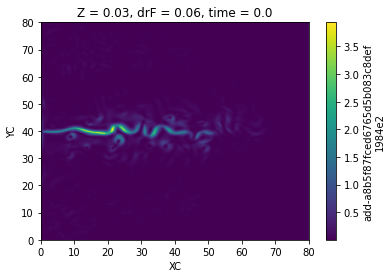

0 <xarray.DataArray 'add-a8b5f87fced6765d5b083c8def1984e2' (time: 312, YC: 1024, XC: 1024)>
dask.array<mul, shape=(312, 1024, 1024), dtype=float64, chunksize=(10, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    Z        float64 0.03
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 308.0 309.0 310.0 311.0


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

10 <xarray.DataArray 'add-83a94bfcbb5a83ad5008fa8f3719e196' (time: 312, YC: 1024, XC: 1024)>
dask.array<mul, shape=(312, 1024, 1024), dtype=float64, chunksize=(10, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    Z        float64 0.03
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 308.0 309.0 310.0 311.0


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [6]:
ver = 0

for i in range(0,nmemb):
    if i < nmemb:
        ds = xr.open_zarr(op.join(rund,'run%03d/vars%03d/' % (i,ver)))
        Psi = (ds.psi*ds.drF).sum('Z')
        ub = -Psi.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
        vb = Psi.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
        BKE = xr.DataArray(ub.isel(Yp1=slice(1,None)).data**2 + ub.isel(Yp1=slice(None,-1)).data**2
                           + vb.isel(Xp1=slice(1,None)).data**2 + vb.isel(Xp1=slice(None,-1)).data**2,
                           dims=ds.q.isel(Z=0).dims, coords=ds.q.isel(Z=0).coords
                          ) * .25
        BKE.drop(['Z','drF']).chunk({'YC':128,'XC':128}
                                   ).to_dataset(name='BKE').to_zarr(op.join(rund,'run%03d/BKE%03d/' % (i,ver)), 
                                                                    mode='w')
        if i == 0:
            BKE.isel(time=0).plot()
            plt.show()
        ds.close()
    else:
        ds = xr.open_zarr(op.join(rund, 'ctrl/vars%03d/' % ver))
        Psi = (ds.psi*ds.drF).sum('Z')
        ub = -Psi.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
        vb = Psi.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
        BKE = xr.DataArray(ub.isel(Yp1=slice(1,None)).data**2 + ub.isel(Yp1=slice(None,-1)).data**2
                                   + vb.isel(Xp1=slice(1,None)).data**2 + vb.isel(Xp1=slice(None,-1)).data**2,
                                   dims=ds.q.isel(Z=0).dims, coords=ds.q.isel(Z=0).coords
                                  ) * .25
        BKE.drop(['Z','drF']).chunk({'YC':128,'XC':128}
                                   ).to_dataset(name='BKE').to_zarr(op.join(rund,'ctrl/BKE%03d/' % ver), 
                                                                    mode='w')
        
    if i % 10 == 0:
        print(i, BKE)
# dsp1.coords['nmemb'] = ('nmemb',range(nmemb+1))
# time = ds.t.data
# ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
# ds.coords['time'] = ('time',time)
# ds.coords['timeC'] = ('timeC',.5*(time[1:] + time[:-1]))
# ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
# ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
# ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
# ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
# ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
# dsp1 = dsp1.chunk({'nmemb':4})

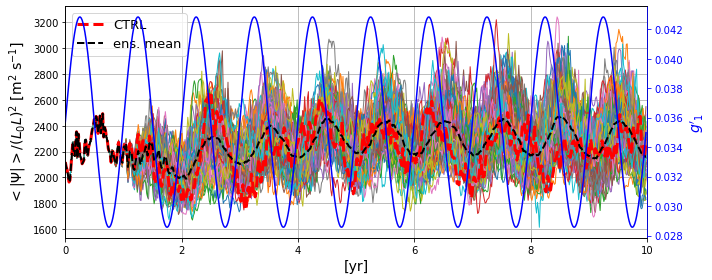

In [20]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(ds.time*tau/(diny*86400),
                absPsib.isel(nmemb=i)*U*Rd, lw=1)
    else:
        ax.plot(ds.time*tau/(diny*86400),
                absPsib.isel(nmemb=i)*U*Rd, 
                'r--', label=r'CTRL', lw=3)
        
ax.plot(ds.time*tau/(diny*86400),
        absPsib.mean('nmemb')*U*Rd, 'k--', lw=2,
        label=r'ens. mean')

ax2.plot(ds.time*tau/(diny*86400), gp.isel(Zp1=0)*U**2/H, 'b')

ax.set_xlim([0,10])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$<|\Psi|>/(L_0L)^2$ [m$^2$ s$^{-1}$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/Psi_spread.pdf'))

In [6]:
# psi_padded = xr.DataArray(pad_bc(ds.p.isel(Z=0)), 
#                           dims=['nmemb','time','Yp1','Xp1'],
#                           coords={'nmemb':range(nmemb+1),'time':ds.time.data,
#                                   'Yp1':np.arange(-dx/2,L0+dx,dx),
#                                   'Xp1':np.arange(-dx/2,L0+dx,dx)}
#                          ).chunk({'nmemb':10,'time':10,'Yp1':100,'Xp1':100})
# u1 = -ds.psi.isel(Z=0,Xp1=slice(1,-1)).diff('Yp1') / dx
# v1 = ds.psi.isel(Z=0,Yp1=slice(1,-1)).diff('Xp1') / dx
# TKE1 = xr.DataArray(u1.isel(Yp1=slice(1,None)).data**2 + u1.isel(Yp1=slice(None,-1)).data**2
#                     + v1.isel(Xp1=slice(1,None)).data**2 + v1.isel(Xp1=slice(None,-1)).data**2,
#                     dims=ds.q.isel(Z=0).dims, coords=ds.q.isel(Z=0).coords
#                    ) * .25
ver = 1
# import warnings
# warnings.filterwarnings("ignore")

for i in range(66,nmemb+1):
    if i < nmemb:
        ds = xr.open_zarr(op.join(rund,'run%03d/vars%03d/' % (i,ver)))
        u = -ds.psi.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
        v = ds.psi.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
        TKE = xr.DataArray(u.isel(Yp1=slice(1,None)).data**2 
                           + u.isel(Yp1=slice(None,-1)).data**2
                           + v.isel(Xp1=slice(1,None)).data**2 
                           + v.isel(Xp1=slice(None,-1)).data**2,
                           dims=ds.q.dims, coords=ds.q.coords
                          ) * .25
        Psi = (ds.psi*ds.drF).sum('Z')
        U = -Psi.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
        V = Psi.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
        BKE = xr.DataArray(U.isel(Yp1=slice(1,None)).data**2 
                           + U.isel(Yp1=slice(None,-1)).data**2
                           + V.isel(Xp1=slice(1,None)).data**2 
                           + V.isel(Xp1=slice(None,-1)).data**2,
                           dims=ds.q.isel(Z=0).dims, coords=ds.q.isel(Z=0).coords
                          ) * .25
        dsave = TKE.to_dataset(name='TKE')
        dsave['BKE'] = BKE
        dsave.chunk({'YC':128,'XC':128}).to_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,ver)), mode='w')
        if i == 0:
            BKE.isel(time=0).plot()
            plt.show()
        dsave.close()
        ds.close()
    else:
        ds = xr.open_zarr(op.join(rund, 'ctrl/vars%03d/' % ver))
        u = -ds.psi.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
        v = ds.psi.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
        TKE = xr.DataArray(u.isel(Yp1=slice(1,None)).data**2 
                           + u.isel(Yp1=slice(None,-1)).data**2
                           + v.isel(Xp1=slice(1,None)).data**2 
                           + v.isel(Xp1=slice(None,-1)).data**2,
                           dims=ds.q.dims, coords=ds.q.coords
                          ) * .25
        Psi = (ds.psi*ds.drF).sum('Z')
        U = -Psi.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
        V = Psi.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
        BKE = xr.DataArray(U.isel(Yp1=slice(1,None)).data**2 
                           + U.isel(Yp1=slice(None,-1)).data**2
                           + V.isel(Xp1=slice(1,None)).data**2 
                           + V.isel(Xp1=slice(None,-1)).data**2,
                           dims=ds.q.isel(Z=0).dims, coords=ds.q.isel(Z=0).coords
                          ) * .25
        dsave = TKE.to_dataset(name='TKE')
        dsave['BKE'] = BKE
        dsave.chunk({'YC':128,'XC':128}).to_zarr(op.join(rund,'ctrl/TKE%03d/' % ver), mode='w')
        
    if i % 5 == 0:
        print(i)
    if i % 10 == 0.:
        print(BKE)
    del TKE, BKE
# dsp1.coords['nmemb'] = ('nmemb',range(nmemb+1))
# time = ds.t.data
# ds = ds.rename({'t':'time','z':'Z','y':'YC','x':'XC'})
# ds.coords['time'] = ('time',time)
# ds.coords['timeC'] = ('timeC',.5*(time[1:] + time[:-1]))
# ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
# ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
# ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
# ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
# ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
# dsp1 = dsp1.chunk({'nmemb':4})
# absPsi1b = np.abs(ds.p.isel(Z=0)).mean(['YC','XC']).compute()

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

70
<xarray.DataArray 'add-a8ded99e0045e9981ccac5e6c6fe0ec9' (time: 312, YC: 1024, XC: 1024)>
dask.array<mul, shape=(312, 1024, 1024), dtype=float64, chunksize=(10, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    Z        float64 0.03
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

75


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

80
<xarray.DataArray 'add-f1b0d0bba3ac5751948abd2f2c1516d0' (time: 312, YC: 1024, XC: 1024)>
dask.array<mul, shape=(312, 1024, 1024), dtype=float64, chunksize=(10, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    Z        float64 0.03
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

85


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

90
<xarray.DataArray 'add-38d9a0ca327c83d6295303afb59ac4da' (time: 312, YC: 1024, XC: 1024)>
dask.array<mul, shape=(312, 1024, 1024), dtype=float64, chunksize=(10, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    Z        float64 0.03
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

95


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

100
<xarray.DataArray 'add-c0ec22fa6e70348257629473e863d4a8' (time: 312, YC: 1024, XC: 1024)>
dask.array<mul, shape=(312, 1024, 1024), dtype=float64, chunksize=(10, 98, 98), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    Z        float64 0.03
    drF      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) float32 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0


In [7]:
for i in range(nmemb+1):
    if i < nmemb:
        if i == 0:
            BKEb = xr.concat([xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,0))),
                              xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,1))).isel(time=slice(1,None))
                             ], 'time').BKE.sum(['YC','XC']).compute() * dx**2
        else:
            BKEb = xr.concat([BKEb, xr.concat([xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,0))),
                                               xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,1))).isel(time=slice(1,None))
                                              ], 'time').BKE.sum(['YC','XC']).compute() * dx**2
                             ], 'nmemb')                 
    else:
        BKEb = xr.concat([BKEb, xr.concat([xr.open_zarr(op.join(rund,'ctrl/TKE%03d/' % 0)),
                                           xr.open_zarr(op.join(rund,'ctrl/TKE%03d/' % 1)).isel(time=slice(1,None))
                                          ], 'time').BKE.sum(['YC','XC']).compute() * dx**2
                         ], 'nmemb')
    if i % 10 == 0.:
        print(i)
BKEb

0
10
20
30
40


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

KeyboardInterrupt: 

In [9]:
for i in range(nmemb+1):
    if i < nmemb:
        if i == 0:
            BKEb = xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' 
                                        % (i,1))
                               ).BKE.sum(['YC','XC']).compute() * dx**2
        else:
            BKEb = xr.concat([BKEb, xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' 
                                                         % (i,1))
                                                ).BKE.sum(['YC','XC']).compute() * dx**2
                             ], 'nmemb')                 
    else:
        BKEb = xr.concat([BKEb, xr.open_zarr(op.join(rund,'ctrl/TKE%03d/' 
                                                     % 1)
                                            ).BKE.sum(['YC','XC']).compute() * dx**2
                         ], 'nmemb')
    if i % 10 == 0.:
        print(i)

0
10
20
30
40
50
60
70
80
90
100


ValueError: object too deep for desired array

In [17]:
T = 5e5
print((np.argmax(np.correlate((BKEb.mean('nmemb')
                               - BKEb.mean('nmemb').mean('time')), 
                              (gp.isel(time=slice(-len(BKEb.time),None),Zp1=0)
                               - gp.isel(time=slice(-len(BKEb.time),None),Zp1=0).mean()
                              ), mode='full'
                             ))- (ntime - 1.)
      ) * T/86400.)

40.50925925925926


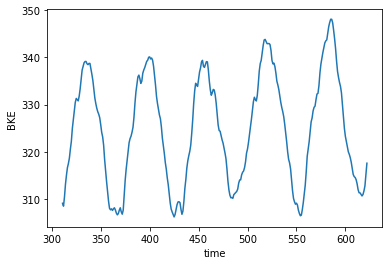

In [13]:
BKEb.mean('nmemb').plot()

In [9]:
# absPsib = np.abs(Psi).mean(['YC','XC']).compute()
BKEbstd = BKEb.std('nmemb')

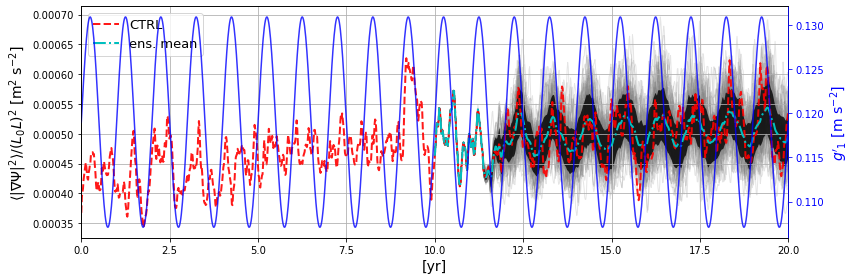

In [26]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400),
                BKEb.isel(nmemb=i) * U**2 / (dx*N)**2, lw=1, alpha=.2, c='grey', zorder=0)
    else:
        ax.plot(np.arange(len(BKEspin.time)*2-1)*tau/(diny*86400),
                np.concatenate((BKEspinb.isel(time=slice(None,-1)),BKEb.isel(nmemb=i,time=slice(None,None)))) * U**2 / (dx*N)**2, 
                'r--', label=r'CTRL', lw=2, alpha=.9)
        
ax.fill_between(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400),
                (BKEb.mean('nmemb')-BKEbstd) * U**2 / (dx*N)**2, 
                (BKEb.mean('nmemb')+BKEbstd) * U**2 / (dx*N)**2,
                facecolor='black', alpha=.8
               )

ax.plot(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400),
        BKEb.mean('nmemb') * U**2 / (dx*N)**2, c='c', ls='-.', lw=2,
        label=r'ens. mean')

ax2.plot(np.arange(len(BKEspin.time)*2-1)*tau/(diny*86400), 
         np.concatenate((gp.isel(Zp1=0), gp.isel(Zp1=0,time=slice(1,None)))) * U**2/(dspin1.drC.isel(Zp1=1).data*H), 
         'b', alpha=.8)

ax.set_xlim([0,20])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$\langle |\nabla\Psi|^2\rangle / (L_0L)^2$ [m$^2$ s$^{-2}$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$ [m s$^{-2}$]", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(rund,'Figs/BarotropicTKE_spread.pdf'))

In [27]:
for i in range(nmemb+1):
    if i < nmemb:
        if i == 0:
            TKE1b = xr.concat([xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,0))
                                           ).TKE.isel(Z=0).sum(['YC','XC']).compute(),
                               xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,1))
                                           ).TKE.isel(time=slice(1,None),Z=0).sum(['YC','XC']).compute()
                              ], 'time') * dx**2
        else:
            TKE1b = xr.concat([TKE1b, xr.concat([xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,0))
                                                             ).TKE.isel(Z=0).sum(['YC','XC']).compute(),
                                                 xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' % (i,1))
                                                             ).TKE.isel(time=slice(1,None),Z=0).sum(['YC','XC']).compute()
                                                ], 'time') * dx**2
                              ], 'nmemb')                 
    else:
        TKE1b = xr.concat([TKE1b, xr.concat([xr.open_zarr(op.join(rund,'ctrl/TKE%03d/' % 0)
                                                         ).TKE.isel(Z=0).sum(['YC','XC']).compute(),
                                             xr.open_zarr(op.join(rund,'ctrl/TKE%03d/' % 1)
                                                         ).TKE.isel(time=slice(1,None),Z=0).sum(['YC','XC']).compute()
                                            ], 'time') * dx**2
                          ], 'nmemb')
    if i % 10 == 0:
        print(i)
    
TKE1b

0
10
20
30


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


40


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


50
60
70


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


80


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

90


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

100


<xarray.DataArray 'TKE' (nmemb: 101, time: 623)>
array([[ 9276.154 ,  9462.751 ,  9664.212 , ...,  9553.44  ,  9692.234 ,
         9734.377 ],
       [ 9276.154 ,  9462.751 ,  9664.212 , ...,  9308.9375,  9593.579 ,
         9847.704 ],
       [ 9276.154 ,  9462.751 ,  9664.212 , ..., 10142.633 , 10235.539 ,
        10164.2   ],
       ...,
       [ 9276.154 ,  9462.751 ,  9664.212 , ...,  9521.817 ,  9802.6   ,
        10123.302 ],
       [ 9276.154 ,  9462.751 ,  9664.212 , ...,  8707.354 ,  8868.897 ,
         9132.358 ],
       [ 9276.154 ,  9462.751 ,  9664.212 , ...,  9859.45  ,  9924.149 ,
         9856.319 ]], dtype=float32)
Coordinates:
    Z        float64 0.03
    drF      float64 0.06
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 ... 619.0 620.0 621.0 622.0
Dimensions without coordinates: nmemb

In [28]:
TKE1bstd = TKE1b.std(['nmemb'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(ds.time*tau/(diny*86400),
                absPsi1b.isel(nmemb=i)*U*Rd, lw=1)
    else:
        ax.plot(ds.time*tau/(diny*86400),
                absPsi1b.isel(nmemb=i)*U*Rd, 
                'r--', label=r'CTRL', lw=3)
        
ax.plot(ds.time*tau/(diny*86400),
        absPsi1b.mean('nmemb')*U*Rd, 'k--', lw=2,
        label=r'ens. mean')

ax2.plot(ds.time*tau/(diny*86400), gp.isel(Zp1=0)*U**2/H, 'b')

ax.set_xlim([0,10])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$<|\Psi_1|>/(L_0L)^2$ [m$^2$ s$^{-1}$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/Psi1_spread.pdf'))

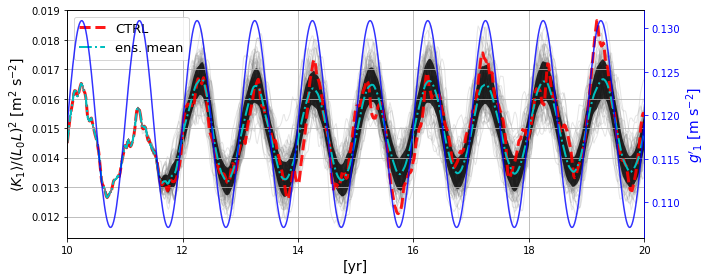

In [32]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400),
                TKE1b.isel(nmemb=i) * U**2 / (dx*N)**2, lw=1, alpha=.2, c='grey', zorder=0)
    else:
        ax.plot(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400),
                TKE1b.isel(nmemb=i) * U**2 / (dx*N)**2, 
                'r--', label=r'CTRL', lw=3, alpha=.9)
        
ax.fill_between(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400),
                (TKE1b.mean('nmemb')-TKE1bstd) * U**2 / (dx*N)**2, 
                (TKE1b.mean('nmemb')+TKE1bstd) * U**2 / (dx*N)**2,
                facecolor='k', alpha=.8
               )
        
ax.plot(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400),
        TKE1b.mean('nmemb') * U**2 / (dx*N)**2, c='c', ls='-.', lw=2,
        label=r'ens. mean')

ax2.plot(np.arange(len(BKEspin.time)-1,len(BKEspin.time)*2-1)*tau/(diny*86400), 
         gp.isel(Zp1=0) * U**2/(dspin1.drC.isel(Zp1=1).data*H), 'b', alpha=.8)

ax.set_xlim([10,20])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$\langle K_1\rangle / (L_0L)^2$ [m$^2$ s$^{-2}$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$ [m s$^{-2}$]", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(rund,'Figs/TKE1_spread.pdf'))

In [8]:
for i in range(nmemb+1):
    if i < nmemb:
        if i == 0:
            TKE2 = xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' 
                                        % (i,1))
                               ).TKE.isel(Z=1).sum(['YC','XC']).compute() * dx**2
        else:
            TKE2 = xr.concat([TKE2, xr.open_zarr(op.join(rund,'run%03d/TKE%03d/' 
                                                         % (i,1))
                                                ).TKE.isel(Z=1).sum(['YC','XC']).compute() * dx**2
                             ], 'nmemb')                 
    else:
        TKE2 = xr.concat([TKE2, xr.open_zarr(op.join(rund,'ctrl/TKE%03d/' 
                                                     % 1)
                                            ).TKE.isel(Z=1).sum(['YC','XC']).compute() * dx**2
                         ], 'nmemb')
    if i % 10 == 0.:
        print(i)

0
10
20
30
40
50
60
70
80
90
100


In [16]:
T = 5e5
print((np.argmax(np.correlate((TKE2.mean('nmemb')
                               - TKE2.mean('nmemb').mean('time')), 
                              (gp.isel(time=slice(-len(TKE2.time),None),Zp1=0)
                               - gp.isel(time=slice(-len(TKE2.time),None),Zp1=0).mean()
                              ), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)

121.52777777777777


In [19]:
# absPsi2b = np.abs(ds.p.isel(Z=1)).mean(['YC','XC']).compute()
psi_padded = pad_bc(ds.p.isel(Z=1))
u2 = -np.diff(psi_padded[...,1:-1], axis=-2) / dx
v2 = np.diff(psi_padded[:,:,1:-1], axis=-1) / dx
TKE2 = xr.DataArray(u2[:,:,1:]**2 + u2[:,:,:-1]**2
                    + v2[...,1:]**2 + v2[...,:-1]**2,
                    dims=ds.p.isel(Z=1).dims, coords=ds.p.isel(Z=1).coords
                   ).chunk({'YC':64,'XC':64}) * .25

TKE2b = TKE2.sum(['YC','XC']).compute() * dx**2
TKE2b

<xarray.DataArray (nmemb: 56, time: 623)>
array([[680.26984, 678.25867, 683.734  , ..., 709.9813 , 709.3633 ,
        711.6212 ],
       [680.26984, 678.25867, 683.734  , ..., 686.7352 , 690.99567,
        695.10376],
       [680.26984, 678.25867, 683.734  , ..., 690.4327 , 691.45044,
        690.38727],
       ...,
       [680.26984, 678.25867, 683.734  , ..., 675.8223 , 668.55524,
        669.41736],
       [680.26984, 678.25867, 683.734  , ..., 690.8289 , 687.6974 ,
        675.4555 ],
       [680.26984, 678.25867, 683.734  , ..., 663.85376, 678.23596,
        698.74243]], dtype=float32)
Coordinates:
    Z        float64 0.03
    drF      float64 0.06
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 619.0 620.0 621.0 622.0
Dimensions without coordinates: nmemb

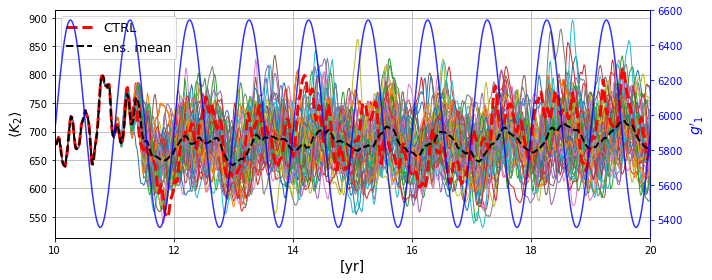

In [25]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400),
                TKE2b.isel(nmemb=i), lw=1)
    else:
        ax.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400),
                TKE2b.isel(nmemb=i), 
                'r--', label=r'CTRL', lw=3)
        
ax.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400),
        TKE2b.mean('nmemb'), 'k--', lw=2,
        label=r'ens. mean')

ax2.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400), gp.isel(Zp1=0), 
         'b', alpha=.8)

ax.set_xlim([10,20])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$\langle K_2\rangle$", fontsize=14)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/TKE2_spread.pdf'))

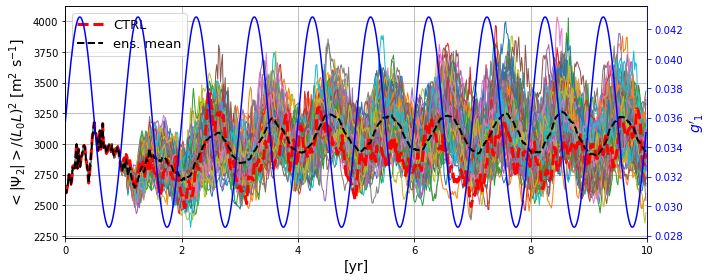

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(ds.time*tau/(diny*86400),
                absPsi2b.isel(nmemb=i)*U*Rd, lw=1)
    else:
        ax.plot(ds.time*tau/(diny*86400),
                absPsi2b.isel(nmemb=i)*U*Rd, 
                'r--', label=r'CTRL', lw=3)
        
ax.plot(ds.time*tau/(diny*86400),
        absPsi2b.mean('nmemb')*U*Rd, 'k--', lw=2,
        label=r'ens. mean')

ax2.plot(ds.time*tau/(diny*86400), gp.isel(Zp1=0)*U**2/H, 'b')

ax.set_xlim([0,10])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$<|\Psi_2|>/(L_0L)^2$ [m$^2$ s$^{-1}$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/Psi2_spread.pdf'))

In [20]:
# absPsi3b = np.abs(ds.p.isel(Z=2)).mean(['YC','XC']).compute()
psi_padded = pad_bc(ds.p.isel(Z=2))
u3 = -np.diff(psi_padded[...,1:-1], axis=-2) / dx
v3 = np.diff(psi_padded[:,:,1:-1], axis=-1) / dx
TKE3 = xr.DataArray(u3[:,:,1:]**2 + u3[:,:,:-1]**2
                    + v3[...,1:]**2 + v3[...,:-1]**2,
                    dims=ds.p.isel(Z=2).dims, coords=ds.p.isel(Z=2).coords
                   ).chunk({'YC':64,'XC':64}) * .25

TKE3b = TKE3.sum(['YC','XC']).compute() * dx**2
TKE3b

<xarray.DataArray (nmemb: 56, time: 623)>
array([[145.73718 , 149.15556 , 148.63953 , ..., 152.40565 , 154.49739 ,
        159.07216 ],
       [145.73718 , 149.15556 , 148.63953 , ..., 137.5273  , 139.0527  ,
        138.70612 ],
       [145.73718 , 149.15556 , 148.63951 , ..., 139.5094  , 134.13786 ,
        130.49988 ],
       ...,
       [145.73718 , 149.15556 , 148.63953 , ..., 122.79152 , 121.08856 ,
        118.879684],
       [145.73718 , 149.15556 , 148.63953 , ..., 143.51501 , 138.07419 ,
        131.53725 ],
       [145.73718 , 149.15556 , 148.63953 , ..., 108.87294 , 113.986244,
        122.877594]], dtype=float32)
Coordinates:
    Z        float64 0.6
    drF      float64 0.8
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 619.0 620.0 621.0 622.0
Dimensions without coordinates: nmemb

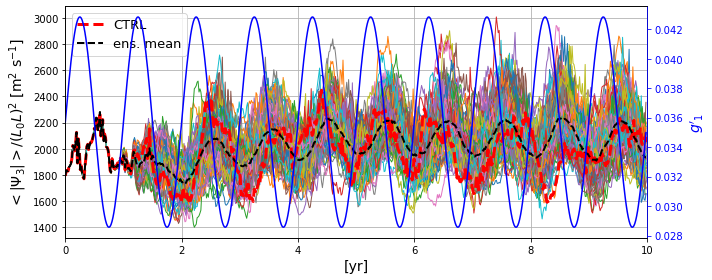

In [24]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(ds.time*tau/(diny*86400),
                absPsi3b.isel(nmemb=i)*U*Rd, lw=1)
    else:
        ax.plot(ds.time*tau/(diny*86400),
                absPsi3b.isel(nmemb=i)*U*Rd, 
                'r--', label=r'CTRL', lw=3)
        
ax.plot(ds.time*tau/(diny*86400),
        absPsi3b.mean('nmemb')*U*Rd, 'k--', lw=2,
        label=r'ens. mean')

ax2.plot(ds.time*tau/(diny*86400), gp.isel(Zp1=0)*U**2/H, 'b')

ax.set_xlim([0,10])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$<|\Psi_3|>/(L_0L)^2$ [m$^2$ s$^{-1}$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/Psi3_spread.pdf'))

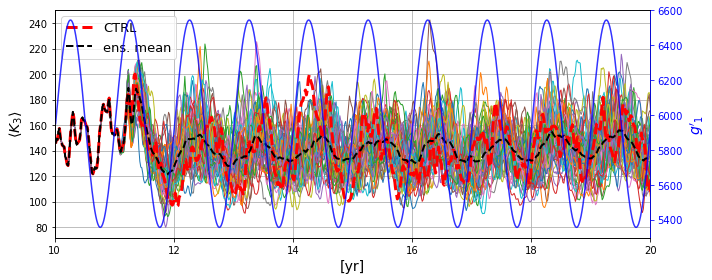

In [26]:
fig, ax = plt.subplots(figsize=(10,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

for i in range(nmemb+1):
    if i < nmemb:
        ax.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400),
                TKE3b.isel(nmemb=i), lw=1)
    else:
        ax.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400),
                TKE3b.isel(nmemb=i), 
                'r--', label=r'CTRL', lw=3)
        
ax.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400),
        TKE3b.mean('nmemb'), 'k--', lw=2,
        label=r'ens. mean')

ax2.plot(np.arange(len(ds.time),len(ds.time)*2)*tau/(diny*86400), gp.isel(Zp1=0), 
         'b', alpha=.8)

ax.set_xlim([10,20])
ax.legend(loc='upper left', fontsize=13)
ax.set_xlabel('[yr]', fontsize=14)
ax.set_ylabel(r"$\langle K_3\rangle$", fontsize=14)
ax2.set_ylabel(r"$g'_1$", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax.grid(True)

plt.savefig(op.join(ddir,'../Figs/TKE3_spread.pdf'))

In [50]:
client.close()